## A raw matrix in geospatial

In geospatial we deal with regular grids that cover a given extent. In this case let's take standard longitude range -180,180 and latitude range -90,90 and generate a 10 degree grid. Each element has its index, so values 0:647. 

In the bad old days there were no labelled arrays, so we might have free-floating information like the range of the grid, here we have xmin,xmax,ymin,ymax - or, we could store a cordinate for each step in the array. 

The first way is a very geospatial-y way to think, each pixel covers a little rectangle on the domain and in this case each has width and height of 10, but all we need to store is the left edge and the right edge because the number of colums already implies perfectly what the spacing between cells is.  


In [2]:
import xarray as xr
import numpy as np
import pyproj
ncol = 36
nrow = 18

## BEHOLD, we have a data structure and its metadata in 5 simple pieces, ship it
aa = (np.arange(ncol * nrow).reshape([nrow, ncol]) * np.random.random((nrow,ncol)))
#aa = np.random.random((ncol, nrow))
#aa = np.arange(ncol * nrow) * np.random.random((ncol,nrow))
xmin = -180
xmax = 180
ymin = -90
ymax = 90
import math

In [53]:
np.random.random((ncol,nrow)).shape

(36, 18)

All well and good, we can even plot this with imshow(), we have built a hi-powered GiS and we can retire in full glory. 

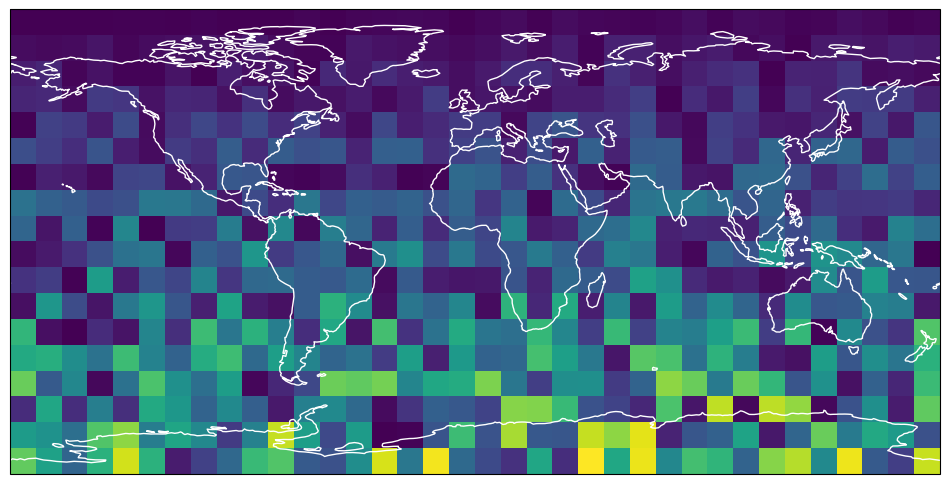

In [3]:
from matplotlib import pyplot
import cartopy.crs as ccrs

proj = ccrs.PlateCarree()  
fig = pyplot.figure(figsize=(12, 12))

ax = pyplot.axes(projection=proj)
ax.imshow(aa, extent = [xmin,xmax,ymin,ymax])

ax.set_xmargin(0.05)
ax.set_ymargin(0.10)
ax.coastlines(color='white')


There's another way to think about the georeferencing we used above, we can convert the four numbers extent to an offset and scale.

In [35]:
offset = [xmin, ymin]
scale = [(xmax - xmin)/aa.shape[1], (ymax - ymin)/aa.shape[0]]
[offset, scale]

[[-180, -90], [10.0, 10.0]]

Above we have stored the bottom left corner of the bottom left cell, and the width and height of each cell.   This is neat because now we can change the size of our array by stride sampling and we only need to update the scale values, or we can take a subset window of the array and only change the offset values. This is very nice in graphics contexts for zooming in and out or displaying different regions, but it's not very nice for a human because we no longer have a compact numeric representation of where our data lives, we need to consult the shape of the data and do calculations (offset, and offset + shape * scale gives us back our extent). 

There's no good or bad here, just a very rich history of choices made for what is most effective in a given context. There are other wrinkles too, when we store the offset take the left edge for offset x and positive scale x, but the top edge for y and negative scale y. (Probably because that's how cathode rays worked, or even maybe because that's how some of us read). 

Another wrinkle is that a modern day affine transform** is expressed in left-edge, top-edge form in software, but in some file formats it is stored as centre-of-left-cell and centre-of-top-cell form (the worldfile). The fact is, however you do it doesn't add any more information to the situation than we had in our original specification: ncol, nrow, xmin, xmax, ymin, ymax - just we need rules and conventions about what a particular representation actually means. 

**(that's a fancy way of saying offset and scale but also has  more generality brought to us by matrix math and graphics magic, math that is truly general and n-dimensional for transforming "things" )

## Georeference the raw matrix

So, we can work with raw structures, we can write this to a geospatial format, we know that our simplest georeferencing consists of six numbers, the shape and the extent. It doesn't really matter how these are expressed as they contain the same information just in different ways. 

- extent: xmin,xmax,ymin,ymax
- bbox:  xmin,ymin,xmax,ymax
- offset,scale: xmin,ymin,xscale,yscale (or xmin,ymax,xscale,-yscale) 
- worldfile xleftcentre,xscale,0,ytopcentre,0,-yscale (check this order)
- geotransform xleft,xscale,0,ytop,0,-yscale
- rasterio affine transform: (slight variants ..., extra parms)

Note on the 0,0 shear stuff. 

Note on how our domain is not equal area / equal distance / conformal or anything like that, but neither is any other grid in any crs (depending on the actual region and scale). This concept of georeferencing is *always* the same, just consider that extent/geotransform can be expressed in angular form (degrees) or in planar form (metres, kilometres, feet etc) but this form of georeferencing takes absolutely no account of the units or their meaning in that sense. WYSIWYG. (Other implications arise later on, and may have implications here but not in our current scope). 

So how can we do this? Write to file, write to worldfile (works for pgw, jgw, tfw, etc. but why do that). 

In order of decreasing "abstraction complexity", but our first one works directly from in memory in Python already. 

### MEM and DATAPOINTER

This is a bit of scary trick, but GDAL has a *memory* driver (driver means software handler for a given format), called MEM. The MEM driver includes a few features but one is a compar syntax that points to a block of memory by address and simply declares its shape, transform, interleaving, datatype, and crs. 

To use this we need some helpers to get at a numpy arrays raw address (we are assuming double type here, Float64 in GDAL terms). 

Once we have constructed a DSN (data source name, this is a description of a data source, like a filename, or a DB connection string) we can open that DSN as a dataset. We don't materialize the DSN because the object probably gets garbage collected and the address might change - that happens in R). 

In [5]:
# (1)

## or, we could specify a dataset from a memory address for GDAL
def address(x):
   return x.__array_interface__["data"][0]

## please note I'm just assuming Float64 here DATATYPE and BANDOFFSET factor=8
def mem_dsn(x, extent): 
  nrow,ncol = x.shape
  xmin = extent[0]
  xmax = extent[1]
  ymin = extent[2]
  ymax = extent[3]
  return f"MEM:::DATAPOINTER=\"{address(x)}\",PIXELS={ncol},LINES={nrow},BANDS=1,DATATYPE=Float64,GEOTRANSFORM={xmin}/{(xmax-xmin)/ncol}/0/{ymax}/0/{(ymin-ymax)/nrow},PIXELOFFSET=0,LINEOFFSET=0,BANDOFFSET={ncol * nrow * 8}"

## run but don't save because of maybe garbage collection
print(mem_dsn(aa, [xmin, xmax, ymin, ymax]))

from osgeo import gdal
gdal.UseExceptions()

ds = gdal.Open(mem_dsn(aa, [xmin, xmax, ymin, ymax]))
print(ds.GetGeoTransform()) ## our geotransform version

## more familiar for rectlinear version of that geotransform
import xarray
xarray.open_dataset(mem_dsn(aa, [xmin, xmax, ymin, ymax]), engine = "rasterio")



MEM:::DATAPOINTER="94068133058144",PIXELS=36,LINES=18,BANDS=1,DATATYPE=Float64,GEOTRANSFORM=-180/10.0/0/90/0/-10.0,PIXELOFFSET=0,LINEOFFSET=0,BANDOFFSET=5184
(-180.0, 10.0, 0.0, 90.0, 0.0, -10.0)


<xarray.Dataset>
Dimensions:      (band: 1, x: 36, y: 18)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -175.0 -165.0 -155.0 -145.0 ... 155.0 165.0 175.0
  * y            (y) float64 85.0 75.0 65.0 55.0 ... -55.0 -65.0 -75.0 -85.0
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float64 ...

Now we need an actual file maybe a PNM or a FLT ...

### GDAL and GCPs

### GDAL and a_ullr

### GDAL and VRT

### GDAL convert to geospatial file


## Rectilinear georeferencing

We glossed over the centre-point vs edge-point referencing by offset and scale above. There's a way to represent the position of the cells more explicitly and we can do that in several different ways. 

Let's create lon and lat arrays of the cell centre points. 

In [82]:
## we could generate xs and ys as the centres

clon = [x * (xmax - xmin)/ncol + xmin + (xmax - xmin)/ncol/ 2 for x in range(ncol)] 
clat = [y * (ymax - ymin)/nrow + ymin + (ymax - ymin)/nrow/ 2 for y in range(nrow)] 

In [89]:
elon = [x * (xmax - xmin)/ncol + xmin for x in range(ncol + 1)]
elat = [y * (ymax - ymin)/nrow + ymin for y in range(nrow + 1)]

print([np.NaN, clat])
print(elat)


[nan, [-85.0, -75.0, -65.0, -55.0, -45.0, -35.0, -25.0, -15.0, -5.0, 5.0, 15.0, 25.0, 35.0, 45.0, 55.0, 65.0, 75.0, 85.0]]
[-90.0, -80.0, -70.0, -60.0, -50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0]


## Area vs point representation

This is where the earnest geospatialologist really gets in trouble, A PIXEL IS NOT A LITTLE SQUARE. 

http://alvyray.com/Memos/CG/Microsoft/6_pixel.pdf

No, it's not, and lots of data out there does not fit into an an area (or volume or hypervolume) context. Still, it's an extremely useful and powerful representation for when it works. It can be head-splitting to think about what the *support* of a point array is, do you want your interpolator to work out to the edge of our grid, or only to the centre point of each cell? Which does it do?

(massive long aside about raster method = "bilinear" in R and a mesh representation)


In [ ]:
# and produce a DataArray
ds = xr.DataArray(
    data=aa,
    dims=["x", "y"],
        name = "world10",
    coords=dict(
        lon=(["x"], lon),
        lat=(["y"], lat)
    )
).to_dataset()

In [47]:
ds.world10.to_numpy()

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17],
       [ 18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
         31,  32,  33,  34,  35],
       [ 36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
         49,  50,  51,  52,  53],
       [ 54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71],
       [ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89],
       [ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107],
       [108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125],
       [126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
        139, 140, 141, 142, 143],
       [144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159, 160, 161],
       [162, 163, 164, 165, 166, 167,